In [1]:
# LOAD DEPENDENCIES
import pandas as pd
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector
import warnings
from sklearn.linear_model import LinearRegression

In [2]:
# IMPORT
file_path = r"C:\Users\tcola\OneDrive\Desktop\WORK\STUDY\GSOM\CS50P\MLproj\model.csv"
model = (pd.read_csv(file_path)).drop(columns=['product_category', 'day', ' kw_max_max'])


file_path = r"C:\Users\tcola\OneDrive\Desktop\WORK\STUDY\GSOM\CS50P\MLproj\predictions.csv"
prediction = (pd.read_csv(file_path)).drop(columns=['product_category', 'day', ' kw_max_max'])

In [3]:
#FEATURE SELECT

warnings.filterwarnings("ignore", category=FutureWarning)

X = model.drop(columns=[' shares'])
y = model[' shares']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Forward Selection
forward_selector = SequentialFeatureSelector(LinearRegression(),
                                             k_features='best',
                                             forward=True,
                                             scoring='neg_mean_squared_error',
                                             cv=5)
forward_selector.fit(X_train, y_train)

# Backward Selection
backward_selector = SequentialFeatureSelector(LinearRegression(),
                                              k_features='best',
                                              forward=False,
                                              scoring='neg_mean_squared_error',
                                              cv=5)
backward_selector.fit(X_train, y_train)

# Get the selected features from both methods
forward_features = list(X_train.columns[list(forward_selector.k_feature_idx_)])
backward_features = list(X_train.columns[list(backward_selector.k_feature_idx_)])

# Combine selected features
best_features = list(set(forward_features) | set(backward_features))

print("Selected features from forward selection:", forward_features)
print("Selected features from backward selection:", backward_features)
print("Combined best features:", best_features)

best_features_shares = best_features + [' shares']
model = model[best_features_shares]
prediction = prediction[best_features]

Selected features from forward selection: ['age_days', ' n_tokens_title', ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' kw_min_max', ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg', ' self_reference_avg_sharess', 'topic_shipping', 'topic_packaging', ' global_subjectivity', ' global_rate_positive_words', ' min_positive_polarity', ' avg_negative_polarity']
Selected features from backward selection: ['age_days', ' n_tokens_title', ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' kw_min_max', ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg', ' self_reference_max_shares', 'topic_shipping', 'topic_packaging', ' global_subjectivity', ' global_rate_positive_words', ' min_positive_polarity', ' avg_negative_polarity']
Combined best features: [' kw_avg_avg', ' min_positive_polarity', 'topic_packaging', ' n_tokens_title', ' global_rate_positive_words', ' avg_negative_polarity', ' kw_min_max', 'topic_shipping', 'age_days', ' num_hrefs', ' kw_max_avg', ' num_imgs', ' kw_min_avg', ' global_subjectivity', ' s

In [4]:
# LOG TRANSFORM
model_abs = model.abs()
prediction_abs = prediction.abs()

model_log = np.log1p(model_abs)
prediction_log = np.log1p(prediction_abs)

target = (' shares')

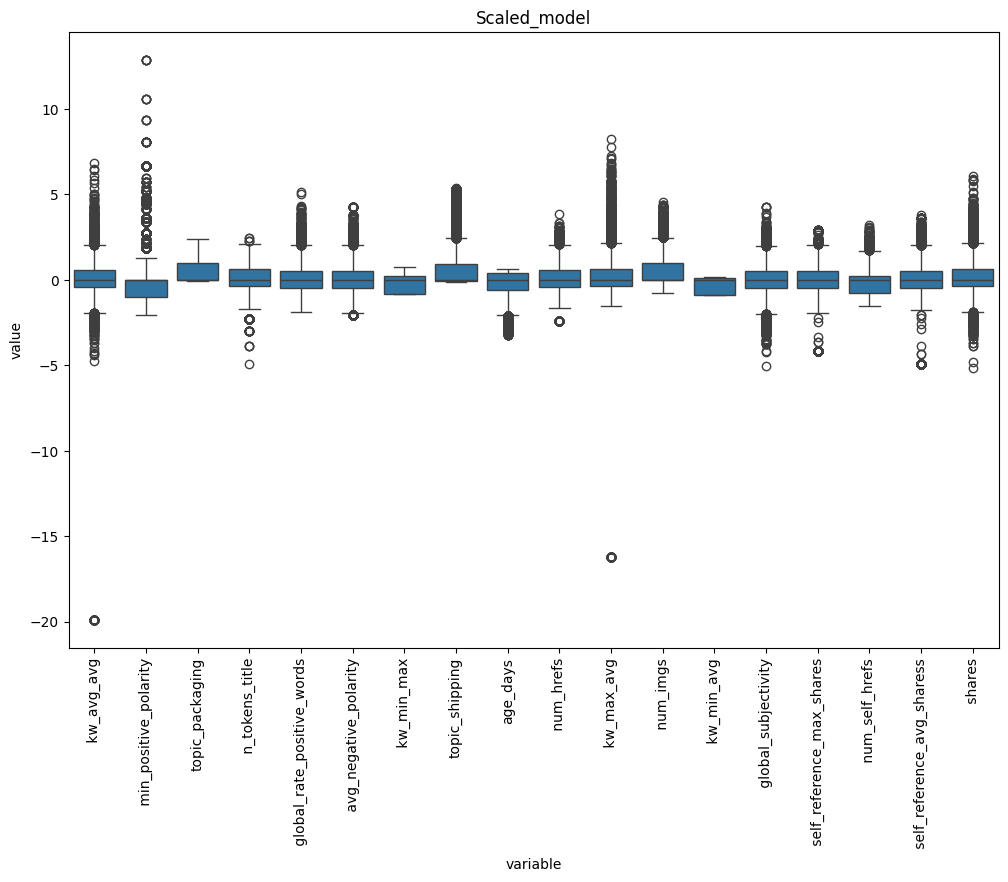

Number of rows in the dataset: 28000


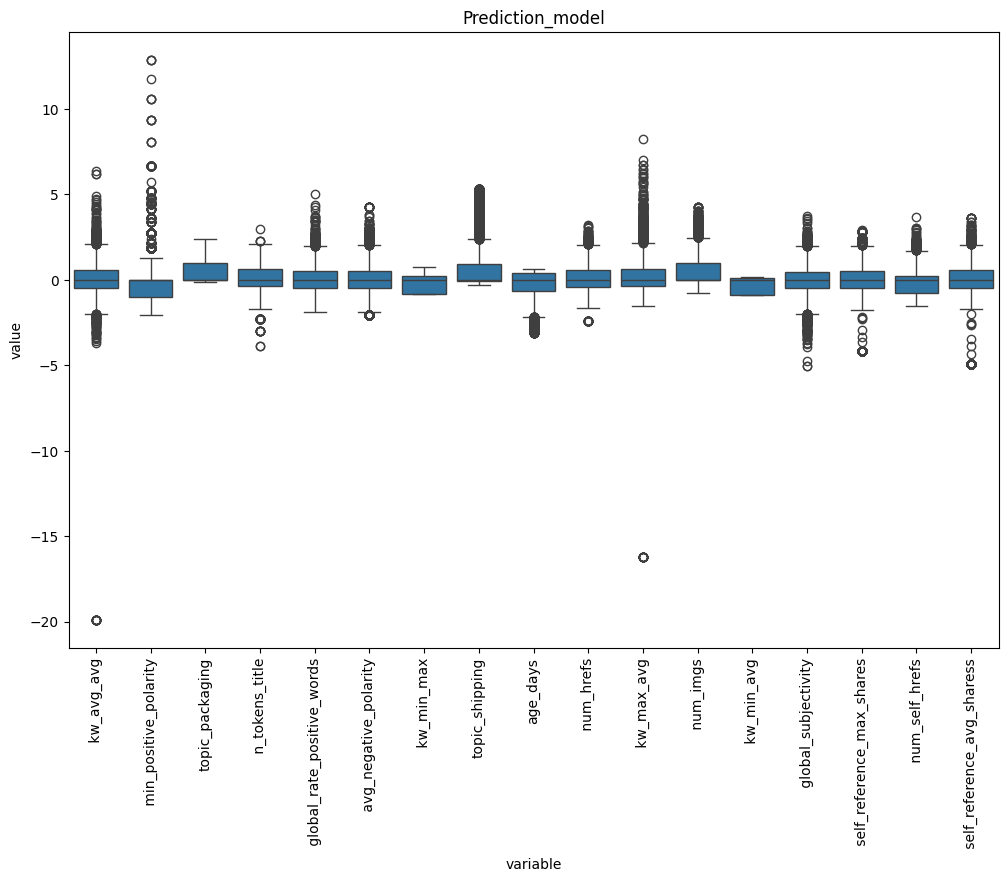

Number of rows in the dataset: 10000


In [5]:
# SCALE DATASETS

x = model_log.drop(columns=[target])
y = model_log[target]

scaler_x = RobustScaler()
scaler_y = RobustScaler()

x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
z_scaled = scaler_x.transform(prediction_log)

x_scaled_df = pd.DataFrame(x_scaled, columns=x.columns)
y_scaled_df = pd.DataFrame(y_scaled, columns=[target])

model_scaled = pd.concat([x_scaled_df, y_scaled_df], axis=1)
prediction_scaled = pd.DataFrame(z_scaled, columns=prediction_log.columns)

# Calculate Z-scores for each column in model_data except shares
z_scores_model = (model_scaled - model_scaled.mean()) / model_scaled.std()
z_scores_prediction = (prediction_scaled - prediction_scaled.mean()) / prediction_scaled.std()

# Define the threshold for outlier detection
threshold = 30

# Identify outliers using boolean indexing
outliers_model = (z_scores_model > threshold) | (z_scores_model < -threshold)
outliers_prediction = (z_scores_prediction > threshold) | (z_scores_prediction < -threshold)
# Remove outliers from model_data
model_1 = pd.DataFrame(model_scaled[~outliers_model.any(axis=1)])
prediction_1 = pd.DataFrame(prediction_scaled[~outliers_prediction.any(axis=1)])

#######################################################################################################################
model_melted = model_1.melt()

plt.figure(figsize=(12, 8))
sns.boxplot(x='variable', y='value', data=model_melted)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("Scaled_model")
plt.show()

num_rows = model_1.shape[0]
print("Number of rows in the dataset:", num_rows)

prediction_melted = prediction_1.melt()

plt.figure(figsize=(12, 8))
sns.boxplot(x='variable', y='value', data=prediction_melted)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("Prediction_model")
plt.show()

num_rows = prediction_1.shape[0]
print("Number of rows in the dataset:", num_rows)
#######################################################################################################################

In [6]:
# TRAIN MLP
X = model_1.drop(columns=[' shares'])
y = model_1[' shares']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(128,), (256,), (128, 64), (256, 128, 64)],
    'activation': ['relu', 'logistic', 'tanh', 'identity'],
    'solver': ['adam', 'lbfgs', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'batch_size': ['auto', 16, 32, 64],
    'early_stopping': [True, False],
    'n_iter_no_change': [5, 10, 20],
    'validation_fraction': [0.1, 0.2, 0.3],
    'random_state': [42]
}

# Initialize MLPRegressor
mlp_regressor = MLPRegressor(max_iter=400)

# Initialize GridSearchCV
grid_search = GridSearchCV(mlp_regressor, param_grid, cv=5, scoring='r2', n_jobs=8)

# Perform GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

# Calculate MAE, MSE, and R2
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_train_pred)

print("Best Parameters:", best_params)
print("Training R2 score:", r2_train)
print("Test R2 score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)


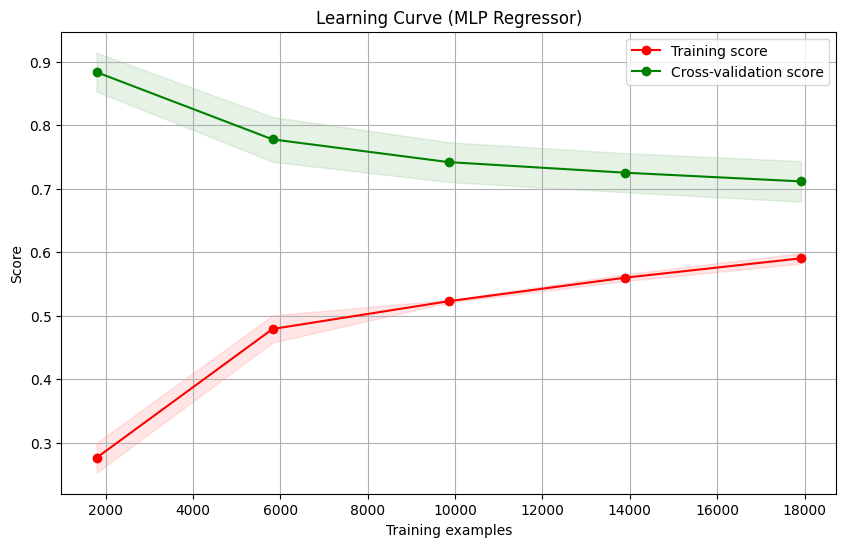

In [ ]:
# PLOT LEARNING CURVES
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve
title = "Learning Curve (MLP Regressor)"
plot_learning_curve(mlp_regressor, title, X_train, y_train, cv=5, n_jobs=-1)
plt.show()

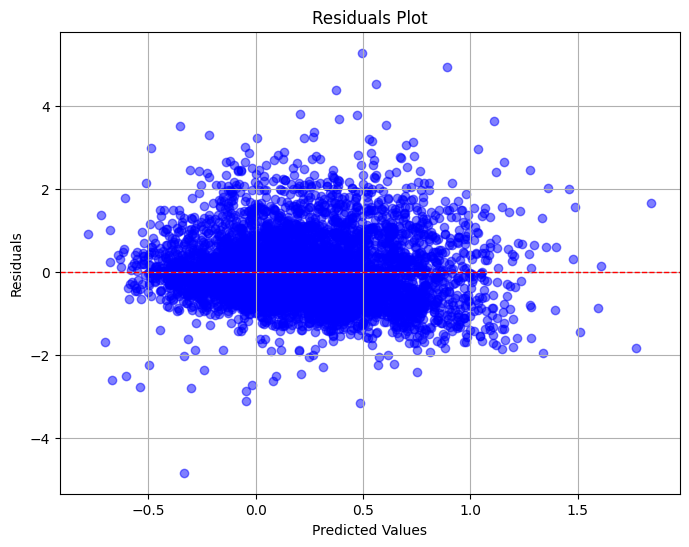

In [ ]:
# PLOT RESIDUALS
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

Step 7: Generate Predictions


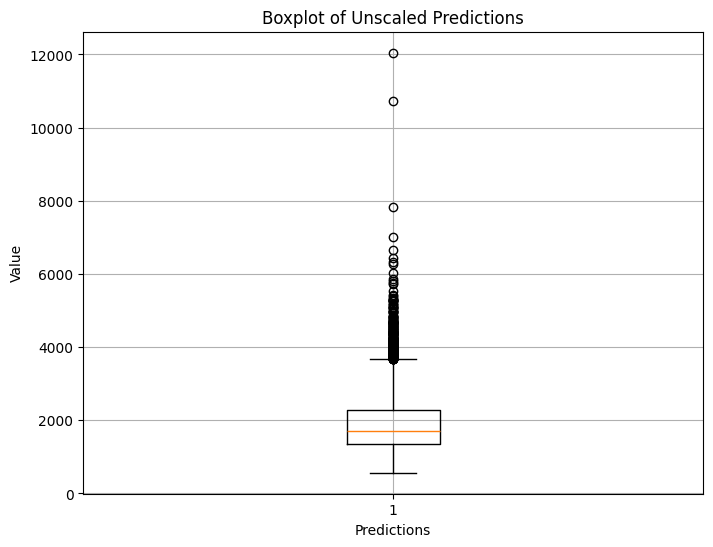

Step 8: Saving predictions to a CSV file
Predictions saved successfully


In [ ]:
# GENERATE PREDICTIONS
print("Step 7: Generate Predictions")

# Predict on the unseen data using the best model
predictions_best_model = best_model.predict(prediction_1)

# Unscale the predictions
unscale = predictions_best_model * scaler_y.scale_ + scaler_y.center_

# Apply inverse log transformation
unlog = np.expm1(unscale)

# Round and cast predictions to integer
unscaled_predictions = np.round(unlog).astype(int)

# Create a boxplot of unscaled predictions
plt.figure(figsize=(8, 6))
plt.boxplot(unscaled_predictions)
plt.title('Boxplot of Unscaled Predictions')
plt.xlabel('Predictions')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Save predictions to a CSV file
print("Step 8: Saving predictions to a CSV file")
predictions_df = pd.DataFrame({'Target': unscaled_predictions.flatten()})
predictions_df.to_csv('predictions_please.csv', index=False)
print("Predictions saved successfully")